In [11]:
import requests
from bs4 import BeautifulSoup
import urllib.request
import re
from datetime import datetime
import pandas as pd
def get_pages(url):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    request = urllib.request.Request(url, headers=headers)
    response = urllib.request.urlopen(request)
    if response.status != 200:
        print("Không thể kết nối đến trang web. Status code: ", response.status)
    else : 
        print("Ok status code 200,tiếp tục lấy dữ liệu")
    html_content = response.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    target_li = [li for li in soup.find_all("li", class_="pageNav-page") 
             if li.get("class") == ["pageNav-page"]]
    page_numbers = [int(li.a.text) for li in target_li if li.a and li.a.text.isdigit()][0]
    print("Số trang max: ", page_numbers)
    return page_numbers
max_page = get_pages("https://voz.vn/t/thread-tong-hop-chia-se-ve-muc-luong-tai-cac-cong-ty-part-2.515355/")


Ok status code 200,tiếp tục lấy dữ liệu
Số trang max:  842


In [ ]:

for page in range(0, max_page):
    url = f"https://voz.vn/t/thread-tong-hop-chia-se-ve-muc-luong-tai-cac-cong-ty-part-2.515355/page-{page}"
    print(url)
    list_1 = []
    list_2 = []
    list_3 = []
    data = []
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}
    request = urllib.request.Request(url, headers=headers)
    response = urllib.request.urlopen(request)
    if response.status != 200:
        print("Không thể kết nối đến trang web. Status code: ", response.status)
    else : 
        print("Ok status code 200,tiếp tục lấy dữ liệu")
    html_content = response.read()
    soup = BeautifulSoup(html_content, 'html.parser')
    posts = soup.find_all('article', class_='message message--post js-post js-inlineModContainer')

    for post in posts:
    # Trích xuất data-author và data-content
        author = post.get('data-author')
        content = post.get('data-content')
    
        # Tìm post id từ data-content
        post_id = re.search(r'post-(\d+)', content).group(1)
        list_1.append({'Author':author, 'Content': content, 'Post ID': post_id})
    # Extract user details
    user_details = soup.find_all('div', class_='message-userDetails')

    for detail in user_details:
        name = detail.find(['span', {'class': 'username--staff username--moderator'}], itemprop='name')
        if name:
            name = name.get_text()
        title = detail.find('h5', class_='userTitle message-userTitle').get_text()
        data_userid = detail.find('a', class_='username')['data-user-id']
        list_2.append({'Name': name, 'Title': title, 'Data-User-ID': data_userid})
    
    menu_text_list = soup.find_all('div', class_='message-cell message-cell--main')
    # tạo 1 dataframe với các columns là post rank, full text = text after blockquote, data quote, data source, title quote, title content, text before blockquote, text after blockquote

    for menu in menu_text_list:
        post_rank_tag = menu.find('ul', class_='message-attribution-opposite message-attribution-opposite--list')
        post_rank_text = post_rank_tag.get_text(strip=True).lstrip("#") if post_rank_tag else None
        post_rank = int(post_rank_text.replace(",", "")) if post_rank_text and post_rank_text.isdigit() else None
        time_string_tag = menu.find('ul', class_ ='message-attribution-main listInline')
        time_string = datetime.strptime(time_string_tag.get_text(strip=True) ,'%b %d, %Y') if time_string_tag else None
        print(f"Post Rank: {post_rank}")
    
        blockquote_list = menu.find_all('blockquote')

    # Nếu không có blockquote hoặc danh sách blockquote rỗng, lấy toàn bộ nội dung của menu_text
        if not blockquote_list:
            full_text = menu.get_text(separator='\n',strip=True) 
        
            data.append({
                'Post Rank': post_rank,
                'Time' : time_string,
                'Full Text': full_text,
                'Data Quote': None,
                'Data Source': None,
                'Title Quote': None,
                'Title Content': None,
                'Text Before Blockquote': None
            
            })

        else:
        # Nếu có blockquote, duyệt từng cái và trích xuất dữ liệu
            for blockquote in blockquote_list:
                data_quote = blockquote.get('data-quote')
                data_source = blockquote.get('data-source')

                title_quote_tag = blockquote.find('div', class_='bbCodeBlock-title')
                title_quote = title_quote_tag.get_text(strip=True) if title_quote_tag else None

                title_content_tag = blockquote.find('div', class_='bbCodeBlock-content')
                title_content = title_content_tag.get_text(strip=True) if title_content_tag else None

                # Lấy text trước và sau blockquote trong menu_text
                text_before_blockquote = blockquote.find_previous_sibling(text=True)
                text_before_blockquote = text_before_blockquote.strip() if text_before_blockquote else None

                text_after_blockquote = blockquote.find_next_sibling(text=True)
                text_after_blockquote = text_after_blockquote.strip() if text_after_blockquote else None
                data.append({
                    'Post Rank': post_rank,
                    'Time' : time_string,
                    'Full Text': text_after_blockquote,
                    'Data Quote': data_quote,
                    'Data Source': data_source,
                    'Title Quote': title_quote,
                    'Title Content': title_content,
                    'Text Before Blockquote': text_before_blockquote
                    })
    df_1 = pd.DataFrame(list_1,columns=['Author', 'Content', 'Post ID'])
    df_2 = pd.DataFrame(list_2,columns=['Name', 'Title', 'Data-User-ID'])
    df_3 = pd.DataFrame(data[:20])
    df = pd.concat([df_1, df_2, df_3], axis=1)
    df.to_csv(f'D:\\Project\\Vietnam-IT-Job-Market-Analysis\\getdata\\csv_folder\\voz_page{page}.csv', index=False)
# Hết tầm 10 phút
    

In [54]:
# Test với Pandas
import pandas as pd
import os

# Thư mục chứa các file CSV
folder_path = "D:\\Project\\Vietnam-IT-Job-Market-Analysis\\getdata\\csv_folder\\Tong_hop_chia_Se_Ve_muc_luong"

# Lấy danh sách tất cả file CSV trong thư mục
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Đọc và gộp tất cả file CSV vào 1 DataFrame
df_pandas = pd.concat([pd.read_csv(os.path.join(folder_path, file)) for file in csv_files], ignore_index=True)



In [56]:
import polars as pl
import os

folder_path = "D:\\Project\\Vietnam-IT-Job-Market-Analysis\\getdata\\csv_folder\\Tong_hop_chia_Se_Ve_muc_luong"
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Đọc file CSV với `infer_schema_length=None` để tránh lỗi schema không khớp
df_list = [pl.read_csv(file, infer_schema_length=None) for file in csv_files]

# Gộp các DataFrame lại
df_polars = pl.concat(df_list, how="vertical_relaxed")



In [55]:
df_pandas

,Author,Content,Post ID,Name,Title,Data-User-ID,Post Rank,Time,Full Text,Data Quote,Data Source,Title Quote,Title Content,Text Before Blockquote
0,Fire Of Heart,post-16589316,16589316,NaN,277;67;6824839,873787,1.0,2022-03-23,"Mar 23, 2022\n#1\nThread cũ bị google quét. Xe...",NaN,NaN,NaN,NaN,NaN
1,Fire Of Heart,post-16589910,16589910,Fire Of Heart,277;67;6824839,873787,2.0,2022-03-23,"Mar 23, 2022\n#2\nThread cũ.\nhttps://voz.vn/t...",NaN,NaN,NaN,NaN,NaN
2,Fire Of Heart,post-16590193,16590193,Fire Of Heart,277;67;6824839,873787,3.0,2022-03-23,để mình xem thử,QTQTQT,post: 16590077,QTQTQT said:,"2,3,4,5 thím nhé. Mà sao thớt đó cũng bị quét ...",NaN
3,teeeeeeeee,post-16590227,16590227,teeeeeeeee,Senior Member,1653529,4.0,2022-03-23,"Mar 23, 2022\n#4\nTên công ty:\nGumi Vietnam\n...",NaN,NaN,NaN,NaN,NaN
4,Fire Of Heart,post-16590237,16590237,Fire Of Heart,277;67;6824839,873787,5.0,2022-03-23,NaN,QTQTQT,post: 16590077,QTQTQT said:,"2,3,4,5 thím nhé. Mà sao thớt đó cũng bị quét ...",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16675,MrTux,post-22583392,22583392,MrTux,Đã tốn tiền,60604,NaN,2023-01-03,"Ốp từ bên kia về, bên này không muốn áp dụng c...",ShjRou,post: 22582677,ShjRou said:,"Bạn mình rất mạnh về tech, các thể loại chứng ...",NaN
16676,becaxiuxinh2018,post-22583587,22583587,becaxiuxinh2018,Senior Member,1825573,NaN,2023-01-03,"Jan 3, 2023\n#1,977\nDù sao giờ trăm hoa đua n...",NaN,NaN,NaN,NaN,NaN
16677,khoahocphothong,post-22585266,22585266,khoahocphothong,Senior Member,151443,NaN,2023-01-03,đặc sản công ty product mà quy mô nhân sự nhỏ,localhost888,post: 22582922,localhost888 said:,Ở Hà Nội có công ty outsoure nào môi trường ok...,NaN
16678,kaitoubg,post-22585473,22585473,kaitoubg,Member,1543133,NaN,2023-01-03,WQ cỡ 7-8 round nhưng có 6 round thực ra tính ...,Fire Of Heart,post: 22512066,Fire Of Heart said:,10 round ko rõ worldquant ngày xưa 6-7 round.C...,NaN


In [47]:
import pandas as pd
import polars as pl
import numpy as np
import time

# Tạo dữ liệu giả lập (10 triệu dòng)
num_rows = 10_000_000
data = {
    "Data-User-ID": np.random.randint(1, 1000000, size=num_rows)  # Tạo số ngẫu nhiên
}

# Pandas DataFrame
df_pandas = pd.DataFrame(data)

# Polars DataFrame
df_polars = pl.DataFrame(data)

# Benchmark Pandas
start_time = time.time()
sum_pandas = df_pandas["Data-User-ID"].sum()
pandas_time = time.time() - start_time
print(f"Pandas sum: {sum_pandas} | Time: {pandas_time:.4f} sec")

# Benchmark Polars
start_time = time.time()
sum_polars = df_polars["Data-User-ID"].sum()
polars_time = time.time() - start_time
print(f"Polars sum: {sum_polars} | Time: {polars_time:.4f} sec")

# So sánh tốc độ
speedup = pandas_time / polars_time
print(f"Polars nhanh hơn Pandas {speedup:.2f} lần")


Pandas sum: 5000658128792 | Time: 0.0120 sec
Polars sum: 1316196248 | Time: 0.0028 sec
Polars nhanh hơn Pandas 4.26 lần


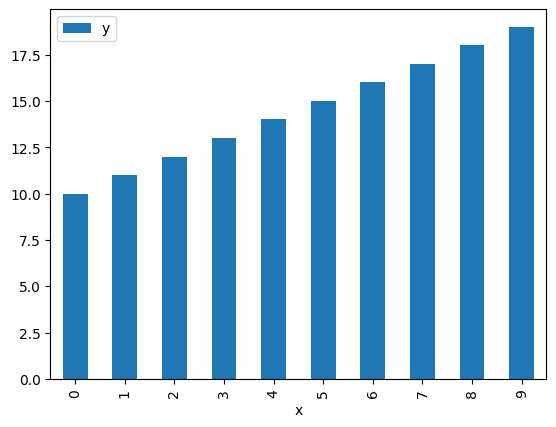

In [48]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame({"x": range(10), "y": range(10, 20)})
df.plot(x="x", y="y", kind="bar")
plt.show()


In [49]:
import polars as pl
import matplotlib.pyplot as plt

df = pl.DataFrame({"x": range(10), "y": range(10, 20)})
df.plot(x="x", y="y", kind="bar")  # ❌ LỖI! Polars không có plot()


ModuleUpgradeRequiredError: altair>=5.4.0 is required for `.plot`

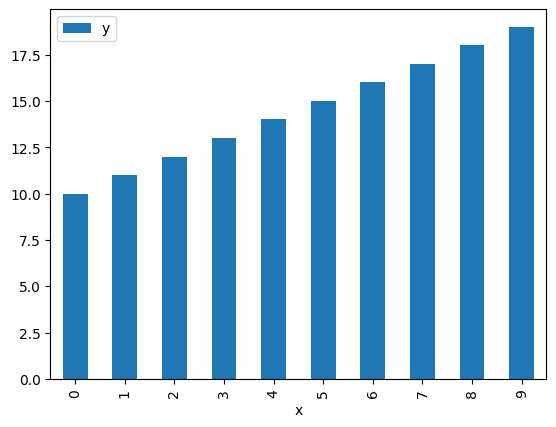

In [50]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt

df_polars = pl.DataFrame({"x": range(10), "y": range(10, 20)})
df_pandas = df_polars.to_pandas()  # Chuyển về Pandas

df_pandas.plot(x="x", y="y", kind="bar")  # Bây giờ mới vẽ được
plt.show()


In [69]:
import time

# Giá trị cần đếm
target_author = "Fire Of Heart"

# Benchmark Pandas
start_time = time.time()
count_pandas = df_pandas["Author"].eq(target_author).sum()  # .eq() nhanh hơn df[df == x]
pandas_time = time.time() - start_time
print(f"Pandas count: {count_pandas} | Time: {pandas_time:.4f} sec")

# Benchmark Polars
start_time = time.time()
count_polars = df_polars.select((pl.col("Author") == target_author).sum()).item()
  # Lọc rồi đếm số dòng
polars_time = time.time() - start_time
print(f"Polars count: {count_polars} | Time: {polars_time:.4f} sec")

# So sánh tốc độ
speedup = pandas_time / polars_time if polars_time > 0 else float('inf')
print(f"Polars nhanh hơn Pandas {speedup:.2f} lần")


Pandas count: 253 | Time: 0.0020 sec
Polars count: 253 | Time: 0.0020 sec
Polars nhanh hơn Pandas 1.00 lần
